In [1]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

In [2]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'

In [3]:
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)

In [4]:
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


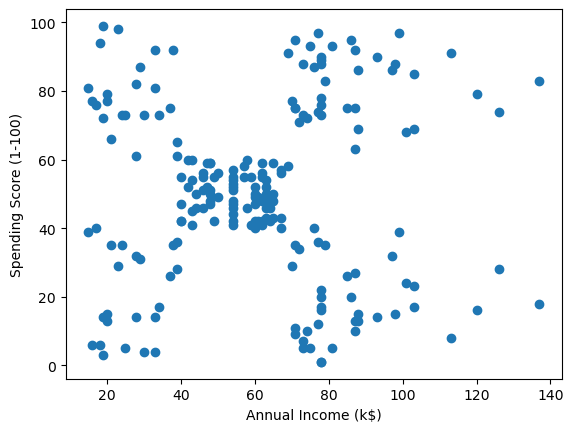

In [6]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

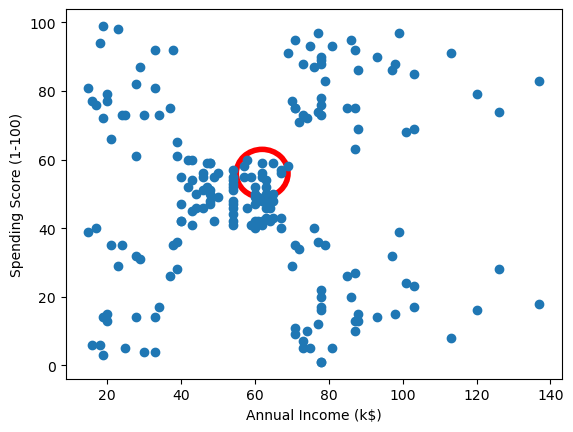

In [7]:
ex_pt = random.randint(0, 199)
from matplotlib.patches import Circle
circle1 = Circle((x[ex_pt], y[ex_pt]), 7, color='r', fill=False, linewidth=4)
fig, ax = plt.subplots()
ax.add_artist(circle1)
ax.scatter(x,y)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
plt.show()
plt.show()

## Explore the Neighborhood

Convert Dataframe to pytorch

In [8]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

Define a threshold radius and a minimum sample

In [9]:
rad = 7.
min_sample = 5

Euclidean Distance between a single x,y coordinate and every other point

Grab any indexes where the distance is less than or equal to radius

Apply indexes

In [10]:
def pt_neighborhood(pt_idx, tens, rad=7.):
    dist = ((tens - tens[pt_idx])**2).sqrt().sum(1)
    return tens[(dist <= rad)]

In [11]:
pt_neighborhood(ex_pt, x_y_tens)

tensor([[57., 58.],
        [57., 55.],
        [59., 55.],
        [60., 52.],
        [62., 59.],
        [62., 55.],
        [62., 56.],
        [63., 50.],
        [63., 52.],
        [63., 54.],
        [65., 59.],
        [67., 57.],
        [67., 56.]], device='cuda:0', dtype=torch.float64)

## Find Core Points

Check each point in neighborhood and see if it's own neighborhood is >= num_sample

In [12]:
ex_pt_neighborhood = pt_neighborhood(ex_pt, x_y_tens)

In [13]:
ex_pt_neighborhood

tensor([[57., 58.],
        [57., 55.],
        [59., 55.],
        [60., 52.],
        [62., 59.],
        [62., 55.],
        [62., 56.],
        [63., 50.],
        [63., 52.],
        [63., 54.],
        [65., 59.],
        [67., 57.],
        [67., 56.]], device='cuda:0', dtype=torch.float64)

In [14]:
ex_pt_neighborhood[0]

tensor([57., 58.], device='cuda:0', dtype=torch.float64)

In [15]:
int(x_y_tens.eq(ex_pt_neighborhood[0]).all(dim=1).nonzero())

86

In [16]:
x_y_tens[135]

tensor([73., 88.], device='cuda:0', dtype=torch.float64)

## Find All Core Points

In [17]:
core_pts = []
non_core_pts = []
for i, pt in enumerate(x_y_tens):
    # test to see if point is core point
    neighborhood = pt_neighborhood(i, x_y_tens)
    if neighborhood.shape[0] >= min_sample:
        # create a boolean tensor to find indexes as integers and append to list
        core_pts.append(x_y_tens[i])
        print(f"{pt} is in the neighborhood")

    else:
        # create a boolean tensor to find indexes as integers and append to list
        non_core_pts.append(x_y_tens[i])
        print(f"{pt} is not in the neighborhood")

core_pts = torch.stack(core_pts)
non_core_pts = torch.stack(non_core_pts)

tensor([15., 39.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([15., 81.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([16.,  6.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([16., 77.], device='cuda:0', dtype=torch.float64) is in the neighborhood
tensor([17., 40.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([17., 76.], device='cuda:0', dtype=torch.float64) is in the neighborhood
tensor([18.,  6.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([18., 94.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([19.,  3.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([19., 72.], device='cuda:0', dtype=torch.float64) is in the neighborhood
tensor([19., 14.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tensor([19., 99.], device='cuda:0', dtype=torch.float64) is not in the neighborhood
tens

In [18]:
core_pts

tensor([[16., 77.],
        [17., 76.],
        [19., 72.],
        [20., 77.],
        [20., 79.],
        [39., 61.],
        [40., 55.],
        [40., 47.],
        [40., 42.],
        [40., 42.],
        [42., 52.],
        [42., 60.],
        [43., 54.],
        [43., 60.],
        [43., 45.],
        [43., 41.],
        [44., 50.],
        [44., 46.],
        [46., 51.],
        [46., 46.],
        [46., 56.],
        [46., 55.],
        [47., 52.],
        [47., 59.],
        [48., 51.],
        [48., 59.],
        [48., 50.],
        [48., 48.],
        [48., 59.],
        [48., 47.],
        [49., 55.],
        [49., 42.],
        [50., 49.],
        [50., 56.],
        [54., 47.],
        [54., 54.],
        [54., 53.],
        [54., 48.],
        [54., 52.],
        [54., 42.],
        [54., 51.],
        [54., 55.],
        [54., 41.],
        [54., 44.],
        [54., 57.],
        [54., 46.],
        [57., 58.],
        [57., 55.],
        [58., 60.],
        [58., 46.],


## Pick a Random Core Point

In [19]:
cluster_init = random.randint(0, core_pts.shape[0])

In [36]:
core_pts[cluster_init][0].detach().cpu().numpy()

array(44.)

In [21]:
neighborhood = pt_neighborhood(cluster_init, core_pts)

In [22]:
neighborhood

tensor([[40., 47.],
        [43., 45.],
        [43., 41.],
        [44., 50.],
        [44., 46.],
        [46., 51.],
        [46., 46.],
        [48., 48.],
        [48., 47.]], device='cuda:0', dtype=torch.float64)

In [23]:
first_cluster_core = []
for i, pt in enumerate(neighborhood):
    neighborhood_core = pt_neighborhood(i, core_pts)
    first_cluster_core.append(core_pts[i])

first_cluster_core = torch.stack(first_cluster_core)

In [24]:
first_cluster_core

tensor([[16., 77.],
        [17., 76.],
        [19., 72.],
        [20., 77.],
        [20., 79.],
        [39., 61.],
        [40., 55.],
        [40., 47.],
        [40., 42.]], device='cuda:0', dtype=torch.float64)

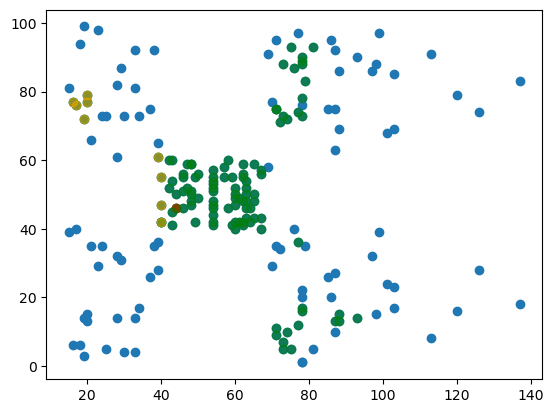

In [38]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.scatter(core_pts[cluster_init][0].detach().cpu().numpy(), core_pts[cluster_init][1].detach().cpu().numpy(), color='red')
ax.scatter(core_pts[:,0].detach().cpu().numpy(), core_pts[:,1].detach().cpu().numpy(), color='green', alpha=0.5)
ax.scatter(first_cluster_core[:,0].detach().cpu().numpy(), first_cluster_core[:,1].detach().cpu().numpy(), color='orange', alpha=0.5)

In [68]:
torch.stack(first_cluster_core)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
def plot_cluster(init_pt, core_pts, )
circle1 = Circle((x_y_tens[ex_pt, 0], x_y_tens[ex_pt, 1]), rad, color='red', fill=False, linewidth=4)
circle2 = Circle((x_y_tens[ex_pt, 0], x_y_tens[ex_pt, 1]), rad, color='green', linewidth=4, alpha=0.5)
fig, ax = plt.subplots()
for coord in range(ex_neighborhood.shape[0]):
    x = int(ex_neighborhood[coord, 0])
    y = int(ex_neighborhood[coord, 1])
    fill_circle = Circle((x, y), rad, color="orange", linewidth=2)
    rad_circle = Circle((x, y), rad, color="red", fill=False, linewidth=4)
    ax.add_artist(fill_circle)
    ax.add_artist(rad_circle)
x = list(x_y_tens[:,0].detach().cpu().numpy())
y = list(x_y_tens[:,1].detach().cpu().numpy())
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.scatter(x,y)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
plt.show()
plt.show()

In [ ]:
import numpy

def dbscan(D, eps, MinPts):
    '''
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    dbscan takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    '''
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = region_query(D, P, eps)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           grow_cluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels


def grow_cluster(D, labels, P, NeighborPts, C, eps, MinPts):
    '''
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    '''

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = region_query(D, Pn, eps)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def region_query(D, P, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if numpy.linalg.norm(D[P] - D[Pn]) < eps:
           neighbors.append(Pn)
            
    return neighbors